In [50]:
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import edward as ed
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
wine_data = pd.read_csv('C:/Users/Rhea/Documents/Bayesian Modeling/Datasets/Wine Quality/winequality-red.csv')

In [2]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_data.describe() 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [55]:
y_data.shape

(1599,)

In [5]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
x_data = (wine_data[features]).as_matrix()
y_data = (wine_data['quality']).as_matrix()

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,random_state=3)

In [25]:
N_Train = x_train.shape[0]  # number of data points
D_Train = x_train.shape[1]  # number of features
N_Test = x_test.shape[0]  # number of data points
D_Test = x_test.shape[1]  # number of features

In [8]:
from edward.models import Normal

X0 = tf.placeholder(tf.float32, [N_Train, D_Train])
w = Normal(loc=tf.zeros(D_Train), scale=tf.ones(D_Train))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y0 = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N_Train))

In [9]:
qw = Normal(loc=tf.get_variable("qw/loc", [D_Train]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D_Train])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

In [29]:
X.shape

TensorShape([Dimension(1199), Dimension(11)])

In [59]:
type(y)

abc.Normal

In [10]:
inference = ed.KLqp({w: qw, b: qb}, data={X: x_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 3558.9790s | Loss: 


In [40]:
X1 = tf.placeholder(tf.float32, [N_Test, D_Test])
y1 = Normal(loc=ed.dot(X1, w) + b, scale=tf.ones(N_Test))

In [41]:
y_post = Normal(loc=ed.dot(X1, qw) + qb, scale=tf.ones(N_Test))

In [42]:
y1.shape

TensorShape([Dimension(400)])

In [43]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X1: x_test, y1: y_test}))

Mean squared error on test data:
9.78407


In [ ]:
print("Mean absolute error on test data:")

In [46]:
print(ed.evaluate('mean_absolute_error', data={X1: x_test, y_post: y_test}))

1.10249


In [51]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

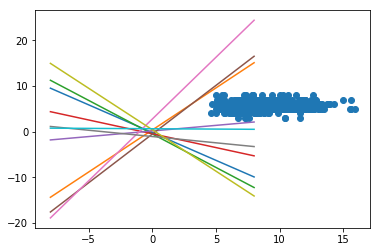

In [52]:
# Visualize samples from the prior.
visualise(x_train, y_train, w, b)

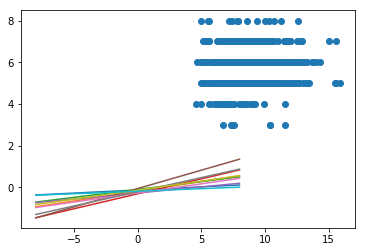

In [53]:
# Visualize samples from the posterior.
visualise(x_train, y_train, qw, qb)